# Nearest Neighbors Gparareal Improving Scalability Of Gaussian Processes For Parallel In Time Solvers

## Solving Viscous Burgers' Equation in Parallel-in-Time

Parallel-in-time (PinT) algorithms provide ways to solve initial value problems for ordinary differential equations (ODEs) and partial differential equations (PDEs) over long time intervals, a task often unfeasible with sequential solvers within realistic timeframes. When remaining resources are available beyond those used for space parallelization (not attempted in this notebook), PinT methodology can be useful to further reduce the runtime.

In this notebook we will solve the Viscous Burgers' equation using the Parareal machinery _sequentially_. The problem size considered is sufficiently small to be run sequentially without requirring specilized hardware or custom setups. We start by importing the relevant packages. 

Note: this is a simplified simulation compared to that in the paper.

In [18]:

import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.linalg import LinAlgWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=LinAlgWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from configs import Config
from systems import Burgers, BurgersFast
from solver import SolverRK
from parareal import PararealLight


Here is an overview of the functionalities:
- `config` contains a sample simulation setup data for each system
- `system` contains ODE/PDE implementations
- `solver` is a thin wrap around the `RK.py` file. It provides APIs for solving ODEs/PDEs numerically. Several solvers are available, including custom-written JAX RK solvers, and access the the numpy `solve_ivp()` method.
- `parareal` contains the Parareal logic. It also contains code for plotting and summarizing simulation outputs in tables. Two implementations are provided, the `Parareal` class, which stores more intermediate data and has more debug functionalities; and the `PararealLight` class, better suited for production code. Under the hood, it relies on the `models.py` file for implementation of the Parareal update, GParareal, NN-GParareal and random weights neural network, also knwon as extreme learning machines (ELMs) .

If `JAX` is not available on your machine, toggle it to False. Expect longer runtimes

In [3]:
use_jax = True

We start by setting up the simulation. For this, we need to define:
- the coarse and fine solvers, $\mathcal{G}$ and $\mathcal{F}$ respectively, together with the number of time discretization points of each solver, $N_\mathcal{G}$ and $N_{\mathcal{F}}$.
- the number of intervals $N$, 
- the number of space discretization points $d_x$, which for Burgers equals to the dimension of the resulting ODE $d$
- the time span $[t_0, t_N]$


In [26]:
dx = 128 # space discretization points
Ng = 4 # number of time steps for the coarse solver, per interval
Nf = 200 # number of time steps for the fine solver, per interval
N = 128 # number of intervals
G = 'RK1' # coarse solver
F = 'RK8' # fine solver

if use_jax:
    ode = Burgers(d_x=dx, normalization='-11', use_jax=use_jax)
else:
    # BurgerFast is optimized to work with numpy only, especially for higher dx
    ode = BurgersFast(d_x=dx, normalization='-11')
f = ode.get_vector_field()

T = 5.9
solver = SolverRK(f, G=G, Ng=Ng, F=F, Nf=Nf, use_jax=use_jax)
para = PararealLight(ode, solver, (0, T), N=N, epsilon=5e-7)

Alternatively, we could have used the config file. They are equivalent.

In [27]:
dx = 128
if use_jax:
    ode = Burgers(d_x=dx, normalization='-11', use_jax=use_jax)
else:
    # BurgerFast is optimized to work with numpy only, especially for higher dx
    ode = BurgersFast(d_x=dx, normalization='-11')
f = ode.get_vector_field()

conf = Config(ode).get()
solver = SolverRK(f, **conf, use_jax=use_jax)
para = PararealLight(ode, solver, **conf, epsilon=5e-7) #set verbose='' to hide intermediate output

We can visually explore how the fine solution is supposed to look

Text(0, 0.5, 'x')

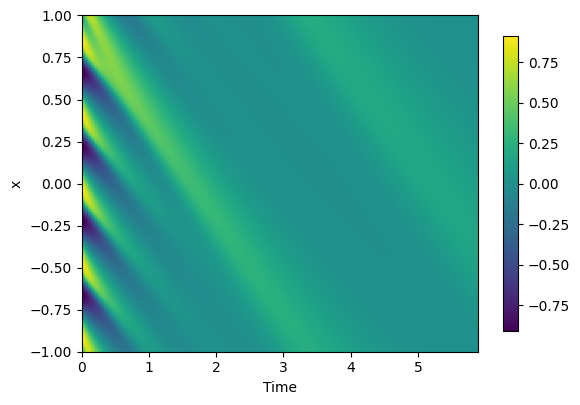

In [28]:
fine_solution = []
current_state = ode.get_init_cond()
t0, T = para.tspan
dt = (T-t0)/N
for i in range(N):
    new_state = solver.run_F(t0+i*dt, t0+(i+1)*dt, current_state)
    fine_solution.append(new_state)
    current_state = new_state
fine_solution = np.stack(fine_solution)

fig, ax = plt.subplots()
cax = ax.imshow(fine_solution.T, aspect=2.5, extent=(0,5.9,-1,1))
cbar = fig.colorbar(cax, shrink=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('x')

Let us evaluate the solution using Parareal, NN-GParareal and with random weights neural netowrks. Note that we have chosen here a smaller value of $N_\mathcal{F}$ to expect a precise simulation output. This is to allow for faster convergence times when run sequentially.

Warning: Parareal can take several minutes to train; NN-GParareal up to 0.5 hours.

In [29]:
res_para = para.run(light=True)
res_elm = para.run(model='elm', degree=1, m=3, light=True)
res_nngp = para.run(model='nngp', light=True, nn=18, pool=10) # pool is for parallelization of the NNGP training

Burgers_128 Parareal iteration number (out of 128): 1 
--> Converged: 1
Burgers_128 Parareal iteration number (out of 128): 2 
--> Converged: 2
Burgers_128 Parareal iteration number (out of 128): 3 
--> Converged: 3
Burgers_128 Parareal iteration number (out of 128): 4 
--> Converged: 4
Burgers_128 Parareal iteration number (out of 128): 5 
--> Converged: 5
Burgers_128 Parareal iteration number (out of 128): 6 
--> Converged: 6
Burgers_128 Parareal iteration number (out of 128): 7 
--> Converged: 7
Burgers_128 Parareal iteration number (out of 128): 8 
--> Converged: 8
Burgers_128 Parareal iteration number (out of 128): 9 
--> Converged: 9
Burgers_128 Parareal iteration number (out of 128): 10 
--> Converged: 10
Burgers_128 Parareal iteration number (out of 128): 11 
--> Converged: 11
Burgers_128 Parareal iteration number (out of 128): 12 
--> Converged: 12
Burgers_128 Parareal iteration number (out of 128): 13 
--> Converged: 13
Burgers_128 Parareal iteration number (out of 128): 14 


We can visually evaluate the performance of each algorithm

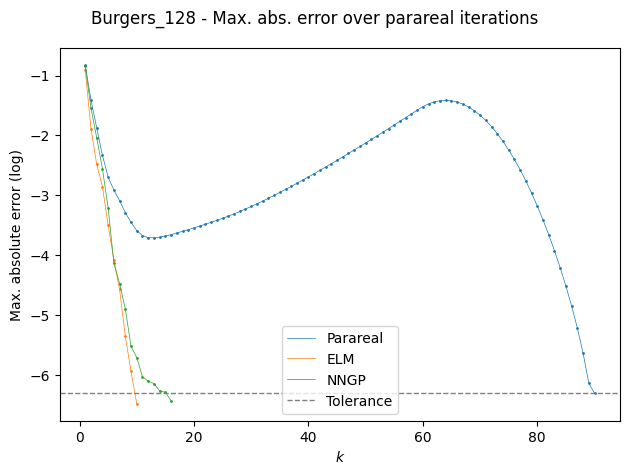

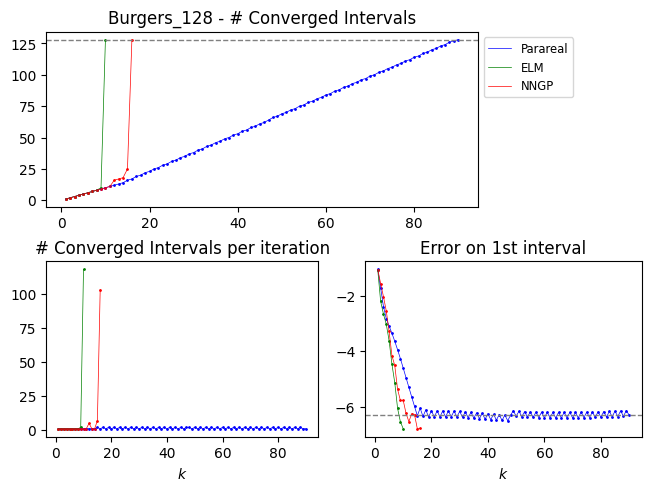

In [31]:
para.plot(skip=[0,1,4])

Finally, we visually check that the result of (any) of the algorithms matches that obtained by the fine solver

Text(0, 0.5, 'x')

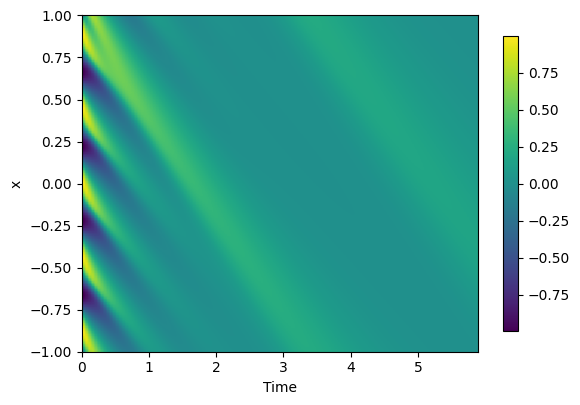

In [33]:
fig, ax = plt.subplots()
cax = ax.imshow(res_elm['u'].T, aspect=2.5, extent=(0,5.9,-1,1))
cbar = fig.colorbar(cax, shrink=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('x')